In [1]:
import numpy as np
import pandas as pd
import random

import torch
from tqdm import tqdm
from torch.utils.data import TensorDataset, DataLoader,Dataset
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

from skimage.transform import resize
from sklearn.metrics import roc_auc_score
import albumentations as A

from pathlib import Path
# import SimpleITK as sitk
# import pydicom
import os,sys
import matplotlib.pyplot as plt
# import cv2

/usr/local/share/anaconda3/envs/shared_env/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Figure out whether we have a GPU; if not use the CPU
device = torch.device('cuda:5' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=5)

In [3]:
meta = pd.read_csv('../zhout/Documents/mask_vol_all.csv')
meta.shape

/tmp/ipykernel_66425/157537160.py:1: DtypeWarning: Columns (9,27,45,59,60,61,76,93,94,98,101,108,112,113,120) have mixed types. Specify dtype option on import or set low_memory=False.
  meta = pd.read_csv('../zhout/Documents/mask_vol_all.csv')


(8461, 124)

In [4]:
meta['file_path'] = meta['PiCare PatientID'] + '_'+ meta['StudyDateAnon'].str.replace('-','') 
meta = meta.query('mask_volume>1000').reset_index(drop=True)
subset = meta.sample(n=50, random_state=29).reset_index(drop=True)
subset['PiCare PatientID'].nunique() # each patient has one roi

49

In [5]:
meta.shape

(1223, 125)

In [6]:
meta['Failure-binary'].value_counts()

0    1000
1     223
Name: Failure-binary, dtype: int64

### Dataset

In [7]:
#!pip install -U albumentations

In [8]:
from albumentations.pytorch import ToTensorV2
import cv2

In [9]:
image_path = meta['image_path']
mask_path = meta['mask_path']

In [10]:
idx = 0
image_array = np.load(image_path[idx])
mask_array = np.load(mask_path[idx])

In [11]:
transforms = A.Compose([
                # spatial transforms
                A.CenterCrop(width=128, height=128),
                A.HorizontalFlip(p=.5),
                A.VerticalFlip(p=.5),
                A.Rotate(limit = 10, 
                        value = 0.0, p = .5),
            ])

In [12]:
img_array = resize(image_array,(32,256,256))
msk_array = resize(mask_array,(32,256,256))
stack_image = np.stack([img_array,msk_array]).transpose()

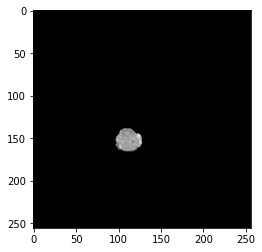

In [13]:
msk_image = img_array*msk_array
plt.imshow(msk_image[10],cmap = 'gray')

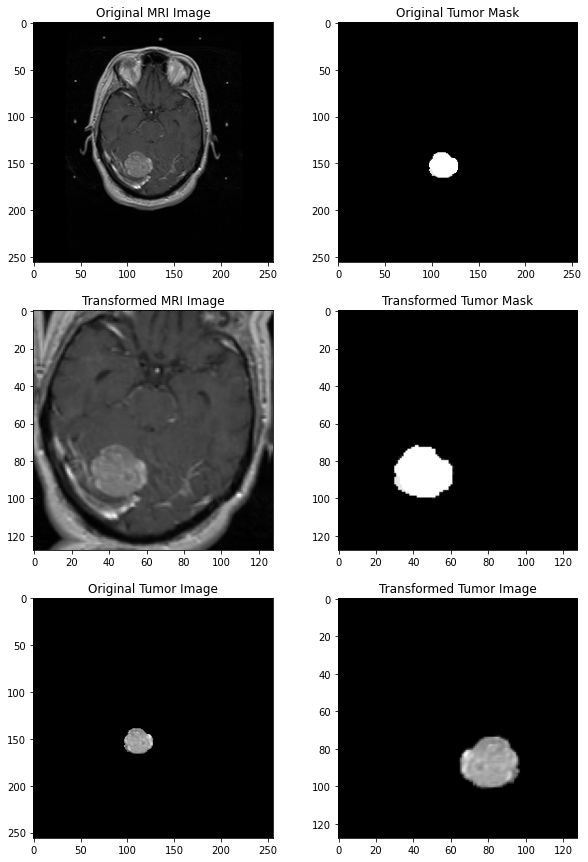

In [14]:
slice_idx = 10

plt.figure(figsize = (10,15))

plt.subplot(3,2,1)
plt.imshow(img_array[slice_idx],cmap = 'gray')
plt.title('Original MRI Image')


plt.subplot(3,2,2)
plt.imshow(msk_array[slice_idx],cmap = 'gray')
plt.title('Original Tumor Mask')

trasimg = transforms(image = img_array.transpose(),mask = msk_array.transpose())
# print(trans_img)
# tranim = a.transpose()
plt.subplot(3,2,3)
plt.imshow(trasimg['image'].transpose()[slice_idx],cmap = 'gray')
plt.title('Transformed MRI Image')

plt.subplot(3,2,4)
plt.imshow(trasimg['mask'].transpose()[slice_idx],cmap = 'gray')
plt.title('Transformed Tumor Mask')

plt.subplot(3,2,5)
msk_image = img_array*msk_array
plt.imshow(msk_image[slice_idx],cmap = 'gray')
plt.title('Original Tumor Image')

trans_msk_img = transforms(image = msk_image.transpose())
plt.subplot(3,2,6)
plt.imshow(trans_msk_img['image'].transpose()[slice_idx],cmap = 'gray')
plt.title('Transformed Tumor Image')

plt.savefig('MRI_img.png',bbox_inches = 'tight')

In [15]:
def read_image_resize(img_path,msk_path,image_size):
    images = []
    for i,m in tqdm(zip(img_path,msk_path)):
        image = np.load(i)
        mask = np.load(m)
        ### Resize and load the image
        filtered = image * mask
        resized_single_image = np.swapaxes(resize(filtered,image_size),2,0)
        images.append(resized_single_image)
    return images 

In [16]:
class BrainMet_Dataset(Dataset):
    def __init__(self, image_path, mask_path, labels, transform = True, img_size = (32,256,256),load_ram = True):
        self.load_ram = load_ram
        if load_ram == True:
            self.filtered = read_image_resize(image_path,mask_path,img_size)
        else:
            self.image_path = image_path
            self.mask_path = mask_path
            
        self.labels = labels
        self.img_size = img_size
        if transform == True:
            self.transformation = A.Compose([
                A.CenterCrop(width=128, height=128),
                A.HorizontalFlip(p=.5),
                A.VerticalFlip(p=.5),
                A.Rotate(limit = 10, 
                        value = 0.0, p = .5),
            ])
            self.transformation = A.Compose([A.CenterCrop(width=128, height=128)])
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self,index):
        y = self.labels[index]
        
        if self.load_ram == True:
            img_array = self.filtered[index]

        else:
            img_array = np.load(self.image_path[index])
            msk_array = np.load(self.mask_path[index])

            img_array = (img_array*msk_array).transpose()

        
        trans = self.transformation(image = img_array)
        trans_img = trans['image'].transpose()
        ### output should be torch tensor
        return torch.tensor([trans_img,trans_img,trans_img],dtype=torch.double), torch.tensor(y,dtype=torch.double)

In [17]:
def get_train_valid(subset):
    np.random.seed(5)
    msk = np.random.rand(len(subset))<0.8
    train = subset[msk].reset_index()
    valid = subset[~msk].reset_index()
    return train,valid

train,valid = get_train_valid(meta)
# train,valid = get_train_valid(subset)


In [18]:
%%time
train_ds = BrainMet_Dataset(train['image_path'],train['mask_path'],train['Failure-binary'])
valid_ds = BrainMet_Dataset(valid['image_path'],valid['mask_path'],valid['Failure-binary'])


984it [11:22,  1.44it/s]
239it [02:31,  1.57it/s]

CPU times: user 11min 5s, sys: 2min 37s, total: 13min 43s
Wall time: 13min 54s


In [19]:
train_dl = DataLoader(train_ds,batch_size=3,shuffle=True)
valid_dl = DataLoader(valid_ds,batch_size=3,shuffle=False)

In [20]:
%%time
a = next(iter(train_dl))

CPU times: user 938 ms, sys: 77.2 ms, total: 1.02 s
Wall time: 521 ms


In [21]:
x,y = a
x.shape,y

(torch.Size([3, 3, 32, 128, 128]), tensor([0., 0., 0.], dtype=torch.float64))

## Resnet Model

In [22]:
import torchvision.models as models

In [24]:
res3d18 = models.video.r3d_18(pretrained=True).to(device)

In [25]:
res3d18

VideoResNet(
  (stem): BasicStem(
    (0): Conv3d(3, 64, kernel_size=(3, 7, 7), stride=(1, 2, 2), padding=(1, 3, 3), bias=False)
    (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Sequential(
        (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (conv2): Sequential(
        (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (relu): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Sequential(
        (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (1):

In [26]:
res3d18.fc = nn.Sequential(nn.Linear(in_features=512,out_features=400),
                           nn.ReLU(),
                           nn.Linear(in_features=400,out_features=1)).to(device)


In [27]:
for param in res3d18.parameters():
    param.requires_grad = False

In [28]:
for param in res3d18.fc.parameters():
    param.requires_grad = True


In [29]:
for name, param in res3d18.named_parameters():
    print(f"{name} gradient is set to", param.requires_grad)

stem.0.weight gradient is set to False
stem.1.weight gradient is set to False
stem.1.bias gradient is set to False
layer1.0.conv1.0.weight gradient is set to False
layer1.0.conv1.1.weight gradient is set to False
layer1.0.conv1.1.bias gradient is set to False
layer1.0.conv2.0.weight gradient is set to False
layer1.0.conv2.1.weight gradient is set to False
layer1.0.conv2.1.bias gradient is set to False
layer1.1.conv1.0.weight gradient is set to False
layer1.1.conv1.1.weight gradient is set to False
layer1.1.conv1.1.bias gradient is set to False
layer1.1.conv2.0.weight gradient is set to False
layer1.1.conv2.1.weight gradient is set to False
layer1.1.conv2.1.bias gradient is set to False
layer2.0.conv1.0.weight gradient is set to False
layer2.0.conv1.1.weight gradient is set to False
layer2.0.conv1.1.bias gradient is set to False
layer2.0.conv2.0.weight gradient is set to False
layer2.0.conv2.1.weight gradient is set to False
layer2.0.conv2.1.bias gradient is set to False
layer2.0.downsa

In [36]:
counts = train['Failure-binary'].value_counts()
pos_weight = torch.tensor(counts[0]/counts.sum()).to(device)

In [31]:
from sklearn.metrics import roc_auc_score,recall_score,precision_score
def train_loop(model,train_dl,valid_dl, optimizer, epochs, loss_best = 1):
    for i in tqdm(range(epochs)): ## going through all your training data once
        model.train()
        losses = []
        for x, y in train_dl:
            y = y.unsqueeze(1)
            x = x.to(device)
            y = y.to(device)
            y_hat = model(x.float())
            loss = F.binary_cross_entropy_with_logits(y_hat, y.float(),pos_weight=pos_weight)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
        
        model.eval()
        train_loss = np.mean(losses)
        valid_loss, valid_acc, valid_roc_auc,precision, recall= val_metric(model, valid_dl)
        print("train loss %.4f valid loss %.4f valid ROC_AUC %.4f valid ACC %.4f valid Precision %.4f valid Recall %.4f" % 
              (train_loss, valid_loss,valid_roc_auc,valid_acc,precision,recall))
        if valid_loss < loss_best:
            checkpoint = {'model_state_dict': model.state_dict(),
                          'optimizer_state_dict' :optimizer.state_dict()}
            torch.save(checkpoint, 'res1.pt')
            loss_best = valid_loss
    return loss_best

In [38]:
def val_metric(model, valid_dl):
    model.eval()
    losses = []
    y_preds = []
    ys = []
    for x, y in valid_dl:  
        y = y.unsqueeze(1)
        x = x.to(device)
        y = y.to(device)
        
        y_hat = model(x.float())
        loss = F.binary_cross_entropy_with_logits(y_hat, y.float(),pos_weight=pos_weight)
        y = y.cpu()
        y_pred = torch.sigmoid(y_hat).cpu()
        y_preds.append(y_pred.detach().numpy())
        ys.extend(y.detach().numpy()) 
        losses.append(loss.item())

    ys = np.concatenate(ys)
    y_hats = np.concatenate(y_preds)
    y_preds_ = np.array([1. if y >=0.5 else 0. for y in y_hats])
    correct = (ys == y_preds_).sum()
    val_acc = correct/len(ys)
    precision = precision_score(ys,y_preds_)
    recall = recall_score(ys,y_preds_)

    return np.mean(losses), val_acc,roc_auc_score(ys,y_hats),precision,recall

In [33]:
%%time


best = 1

CPU times: user 15 µs, sys: 0 ns, total: 15 µs
Wall time: 27.7 µs


In [34]:
learning_rate = 0.01
wd = 1e-4

def update_learning_rate(optimizer, lr):
    for g in optimizer.param_groups:
        g['lr'] = lr

optimizer = torch.optim.Adam(res3d18.parameters(), lr=learning_rate,weight_decay= wd)

In [39]:
%%time
print(best) 
best = train_loop(res3d18,train_dl,valid_dl,optimizer,epochs = 1,loss_best=best)
print(best)
#m3.pt

1


  0%|                                                     | 0/1 [00:00<?, ?it/s]/home/zengy/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


train loss 0.4282 valid loss 0.4616 valid ROC_AUC 0.4809 valid ACC 0.8033 valid Precision 0.0000 valid Recall 0.0000


100%|████████████████████████████████████████████| 1/1 [03:23<00:00, 203.59s/it]

0.4616494775284082
CPU times: user 44min 47s, sys: 4min 52s, total: 49min 40s
Wall time: 3min 23s


In [41]:
%%time
print(best) 
best = train_loop(res3d18,train_dl,valid_dl,optimizer,epochs = 5,loss_best=best)
print(best)
#m3.pt

0.4616494775284082


  0%|                                                     | 0/5 [00:00<?, ?it/s]/home/zengy/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 20%|████████▊                                   | 1/5 [03:52<15:30, 232.58s/it]

train loss 0.4973 valid loss 0.6656 valid ROC_AUC 0.4690 valid ACC 0.8033 valid Precision 0.0000 valid Recall 0.0000


/home/zengy/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


train loss 0.4346 valid loss 0.4352 valid ROC_AUC 0.4974 valid ACC 0.8033 valid Precision 0.0000 valid Recall 0.0000


 40%|█████████████████▌                          | 2/5 [07:52<11:51, 237.12s/it]/home/zengy/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 60%|██████████████████████████▍                 | 3/5 [11:36<07:41, 230.90s/it]

train loss 0.4742 valid loss 0.4352 valid ROC_AUC 0.5263 valid ACC 0.8033 valid Precision 0.0000 valid Recall 0.0000


/home/zengy/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 80%|███████████████████████████████████▏        | 4/5 [15:25<03:50, 230.27s/it]

train loss 0.4402 valid loss 0.4357 valid ROC_AUC 0.5178 valid ACC 0.8033 valid Precision 0.0000 valid Recall 0.0000


/home/zengy/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


train loss 0.4396 valid loss 0.4349 valid ROC_AUC 0.5080 valid ACC 0.8033 valid Precision 0.0000 valid Recall 0.0000


100%|████████████████████████████████████████████| 5/5 [19:11<00:00, 230.26s/it]

0.4348992224782705
CPU times: user 3h 33min 37s, sys: 24min 48s, total: 3h 58min 25s
Wall time: 19min 11s


In [43]:
%%time
def update_learning_rate(optimizer, lr):
    for g in optimizer.param_groups:
        g['lr'] = lr

print(best) 
update_learning_rate(optimizer, 0.001)
best = train_loop(res3d18,train_dl,valid_dl,optimizer,epochs = 15,loss_best=best)
print(best)

0.4348992224782705


  0%|                                                    | 0/15 [00:00<?, ?it/s]/home/zengy/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  7%|██▊                                        | 1/15 [03:32<49:29, 212.08s/it]

train loss 0.4124 valid loss 0.4350 valid ROC_AUC 0.5263 valid ACC 0.8033 valid Precision 0.0000 valid Recall 0.0000


/home/zengy/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 13%|█████▋                                     | 2/15 [07:06<46:16, 213.59s/it]

train loss 0.4123 valid loss 0.4351 valid ROC_AUC 0.5262 valid ACC 0.8033 valid Precision 0.0000 valid Recall 0.0000


/home/zengy/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 20%|████████▌                                  | 3/15 [10:18<40:42, 203.54s/it]

train loss 0.4123 valid loss 0.4351 valid ROC_AUC 0.4850 valid ACC 0.8033 valid Precision 0.0000 valid Recall 0.0000


/home/zengy/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 27%|███████████▍                               | 4/15 [13:38<37:04, 202.23s/it]

train loss 0.4123 valid loss 0.4352 valid ROC_AUC 0.4642 valid ACC 0.8033 valid Precision 0.0000 valid Recall 0.0000


/home/zengy/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 33%|██████████████▎                            | 5/15 [16:55<33:23, 200.32s/it]

train loss 0.4122 valid loss 0.4353 valid ROC_AUC 0.5241 valid ACC 0.8033 valid Precision 0.0000 valid Recall 0.0000


/home/zengy/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 40%|█████████████████▏                         | 6/15 [20:17<30:09, 201.01s/it]

train loss 0.4122 valid loss 0.4353 valid ROC_AUC 0.5055 valid ACC 0.8033 valid Precision 0.0000 valid Recall 0.0000


/home/zengy/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 47%|████████████████████                       | 7/15 [24:04<27:54, 209.25s/it]

train loss 0.4122 valid loss 0.4354 valid ROC_AUC 0.5217 valid ACC 0.8033 valid Precision 0.0000 valid Recall 0.0000


/home/zengy/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 53%|██████████████████████▉                    | 8/15 [27:50<25:02, 214.66s/it]

train loss 0.4122 valid loss 0.4353 valid ROC_AUC 0.5057 valid ACC 0.8033 valid Precision 0.0000 valid Recall 0.0000


/home/zengy/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 60%|█████████████████████████▊                 | 9/15 [31:23<21:25, 214.28s/it]

train loss 0.4122 valid loss 0.4354 valid ROC_AUC 0.5368 valid ACC 0.8033 valid Precision 0.0000 valid Recall 0.0000


/home/zengy/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 67%|████████████████████████████              | 10/15 [34:43<17:29, 209.94s/it]

train loss 0.4123 valid loss 0.4354 valid ROC_AUC 0.4389 valid ACC 0.8033 valid Precision 0.0000 valid Recall 0.0000


/home/zengy/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 73%|██████████████████████████████▊           | 11/15 [37:48<13:28, 202.13s/it]

train loss 0.4122 valid loss 0.4355 valid ROC_AUC 0.5368 valid ACC 0.8033 valid Precision 0.0000 valid Recall 0.0000


/home/zengy/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 80%|█████████████████████████████████▌        | 12/15 [40:51<09:49, 196.34s/it]

train loss 0.4124 valid loss 0.4355 valid ROC_AUC 0.5289 valid ACC 0.8033 valid Precision 0.0000 valid Recall 0.0000


/home/zengy/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 87%|████████████████████████████████████▍     | 13/15 [43:53<06:23, 191.94s/it]

train loss 0.4129 valid loss 0.4355 valid ROC_AUC 0.5134 valid ACC 0.8033 valid Precision 0.0000 valid Recall 0.0000


/home/zengy/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 93%|███████████████████████████████████████▏  | 14/15 [46:50<03:07, 187.57s/it]

train loss 0.4136 valid loss 0.4353 valid ROC_AUC 0.4738 valid ACC 0.8033 valid Precision 0.0000 valid Recall 0.0000


/home/zengy/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
100%|██████████████████████████████████████████| 15/15 [49:53<00:00, 199.58s/it]

train loss 0.4122 valid loss 0.4394 valid ROC_AUC 0.4859 valid ACC 0.8033 valid Precision 0.0000 valid Recall 0.0000
0.4348992224782705
CPU times: user 11h 8min 1s, sys: 1h 13min 45s, total: 12h 21min 47s
Wall time: 49min 53s


In [ ]:
%%time
print(best) 
best = train_loop(model,train_dl,valid_dl,optimizer,epochs = 5,loss_best=best)
print(best)
#m3.pt

In [ ]:
print(val_metric(model, valid_dl))

In [ ]:
%%time
#m3.pt
print(best) 
best = train_loop(model,train_dl,valid_dl,optimizer,epochs = 5,loss_best=best)
print(best)

In [ ]:
%%time
#m3.pt
print(best) 
best = train_loop(model,train_dl,valid_dl,optimizer,epochs = 5,loss_best=best)
print(best)